In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [7]:
np.random.seed(0)  # For reproducibility

n = 1000  # Number of subjects
T = 5     # Number of time periods

# Initialize an empty DataFrame
data = pd.DataFrame(index=range(n))

# Baseline confounder L0
data['L0'] = np.random.binomial(1, 0.5, n)

# Initialize columns for L_t and A_t
for t in range(1, T+1):
    data[f'L{t}'] = np.nan
    data[f'A{t}'] = np.nan

# Simulate data over time
for t in range(1, T+1):
    if t == 1:
        L_prev = data['L0']
        A_prev = 0  # No prior treatment at baseline
    else:
        L_prev = data[f'L{t-1}']
        A_prev = data[f'A{t-1}']

    # Generate L_t based on L_{t-1} and A_{t-1}
    # Ensure probabilities are between 0 and 1
    prob_L = 0.6 * L_prev + 0.2 * A_prev + 0.1
    prob_L = np.clip(prob_L, 0, 1)
    data[f'L{t}'] = np.random.binomial(1, prob_L)

    # Generate A_t based on L_t
    prob_A = 0.7 * data[f'L{t}'] + 0.15
    prob_A = np.clip(prob_A, 0, 1)
    data[f'A{t}'] = np.random.binomial(1, prob_A)

# Generate outcome Y based on cumulative treatments and confounders
data['A_cum'] = data[[f'A{t}' for t in range(1, T+1)]].sum(axis=1)
data['L_cum'] = data[[f'L{t}' for t in range(1, T+1)]].sum(axis=1)

# Linear predictor for outcome
lp = -2 + 0.5 * data['A_cum'] + 0.3 * data['L_cum']
prob_Y = 1 / (1 + np.exp(-lp))
data['Y'] = np.random.binomial(1, prob_Y)

data.head(50)


,L0,L1,A1,L2,A2,L3,A3,L4,A4,L5,A5,A_cum,L_cum,Y
0,1,1,1,1,1,1,1,1,1,1,1,5,5,1
1,1,1,1,1,1,1,1,1,1,0,0,4,4,1
2,1,1,1,1,1,1,1,1,1,1,1,5,5,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,1,1,0,1,2,1,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1,1,1,1,5,5,1
8,1,1,1,1,1,1,1,1,0,1,1,4,5,1
9,0,1,1,1,0,1,0,0,0,0,0,1,3,0


In [5]:
# Model: Y ~ Total Treatment Received
X_std = sm.add_constant(data['A_cum'])
model_std = sm.Logit(data['Y'], X_std)
result_std = model_std.fit(disp=0)

print("Standard Logistic Regression Results:")
print(result_std.summary())


Standard Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Sat, 28 Dec 2024   Pseudo R-squ.:                  0.2282
Time:                        11:31:58   Log-Likelihood:                -530.62
converged:                       True   LL-Null:                       -687.52
Covariance Type:            nonrobust   LLR p-value:                 3.237e-70
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0333      0.143    -14.200      0.000      -2.314      -1.753
A_cum          0.7685      0.050     15.219      0.000       0.670       0.867


In [8]:

# Initialize a column for the denominator of weights
data['weight_denom'] = 1.0

for t in range(1, T+1):
    # Past treatments and confounders up to time t-1
    confounders = [f'L{k}' for k in range(0, t+1)]
    treatments = [f'A{k}' for k in range(1, t)]
    predictors = confounders + treatments
    
    # Treatment at time t
    A_t = data[f'A{t}']
    
    # Design matrix for the model
    X = sm.add_constant(data[predictors])
    
    # Fit logistic regression model
    model = sm.Logit(A_t, X)
    result = model.fit(disp=0)
    
    # Predicted probability P(A_t | history)
    p_denom = result.predict(X)
    
    # Calculate the contribution to the weight
    weight_t = A_t / p_denom + (1 - A_t) / (1 - p_denom)
    data['weight_denom'] *= weight_t

In [10]:
# Initialize a column for the numerator of weights
data['weight_num'] = 1.0

for t in range(1, T+1):
    # Only include past treatments
    treatments = [f'A{k}' for k in range(1, t)]
    predictors = treatments
    
    # Treatment at time t
    A_t = data[f'A{t}']
    
    # Design matrix for the model
    if predictors:
        X = sm.add_constant(data[predictors])
    else:
        X = sm.add_constant(pd.DataFrame({'intercept': np.ones(n)}))
    
    # Fit logistic regression model
    model = sm.Logit(A_t, X)
    result = model.fit(disp=0)
    
    # Predicted probability P(A_t | past A)
    p_num = result.predict(X)
    
    # Calculate the contribution to the weight
    weight_t = A_t / p_num + (1 - A_t) / (1 - p_num)
    data['weight_num'] *= weight_t

In [12]:
# Stabilized weights
data['sw'] = data['weight_num'] / data['weight_denom']

# Check for extreme weights
print("Summary of Stabilized Weights:")
print(data['sw'].describe())

Summary of Stabilized Weights:
count    1000.000000
mean        4.323329
std         4.875725
min         0.006464
25%         1.903003
50%         2.439424
75%         3.678813
max        44.342980
Name: sw, dtype: float64


In [27]:

# Weighted logistic regression using stabilized weights
X_msm = sm.add_constant(data['A_cum'])
model_msm = sm.GLM(data['Y'], X_msm, family=sm.families.Binomial(), var_weights=data['sw'])
result_msm = model_msm.fit()

print("Marginal Structural Model Results:")
print(result_msm.summary())

Marginal Structural Model Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2489.5
Date:                Sat, 28 Dec 2024   Deviance:                       4978.9
Time:                        11:57:30   Pearson chi2:                 4.33e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.6267
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.

In [28]:
coefficients = pd.DataFrame({
    'Model': ['Standard Logistic Regression', 'Marginal Structural Model'],
    'Coefficient': [result_std.params['A_cum'], result_msm.params['A_cum']],
    'Std_Error': [result_std.bse['A_cum'], result_msm.bse['A_cum']]
})

coefficients['Lower_CI'] = coefficients['Coefficient'] - 1.96 * coefficients['Std_Error']
coefficients['Upper_CI'] = coefficients['Coefficient'] + 1.96 * coefficients['Std_Error']

coefficients


,Model,Coefficient,Std_Error,Lower_CI,Upper_CI
0,Standard Logistic Regression,0.768499,0.050496,0.669528,0.867470
1,Marginal Structural Model,0.744417,0.026911,0.691672,0.797161


/var/folders/y1/qh2qb9cs0533z_n8m336hy300000gq/T/ipykernel_62579/3663158425.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='Model', y='Coefficient', data=coefficients, join=False, capsize=0.1)


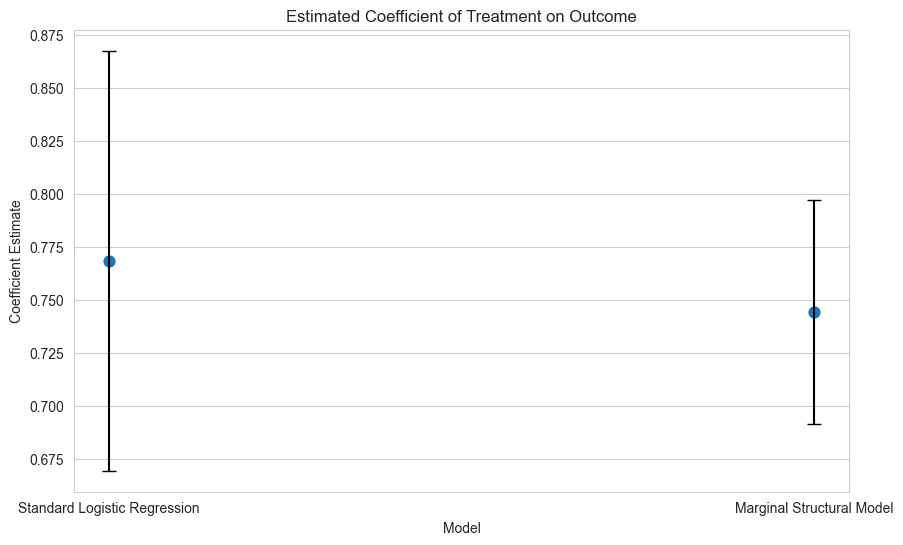

In [29]:
plt.figure(figsize=(10, 6))
sns.pointplot(x='Model', y='Coefficient', data=coefficients, join=False, capsize=0.1)
plt.errorbar(x=[0, 1], y=coefficients['Coefficient'],
             yerr=1.96 * coefficients['Std_Error'], fmt='none', c='black', capsize=5)
plt.title('Estimated Coefficient of Treatment on Outcome')
plt.ylabel('Coefficient Estimate')
plt.show()